# 1 preprocessing 

In [2]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import csv
import gzip
import anndata as ad

In [4]:
# set variables for file paths to read from and write to:

# set a working directory
wdir = "/Users/lidiayung/github/notebooks/GBM/calculation/SF4209"
os.chdir( wdir )

# path to unfiltered loom file (this will be created in the optional steps below)
f_loom_path_unfilt = "SF4209_unfiltered.loom" # test dataset, n=500 cells

# # path to loom file with basic filtering applied (this will be created in the "initial filtering" step below). Optional.
f_loom_path_scenic = "SF4209_filtered_scenic.loom"

# path to anndata object, which will be updated to store Scanpy results as they are generated below
f_anndata_path = "anndata.h5ad"

# path to pyscenic output
f_pyscenic_output = "SF4209_output.loom"
#pyscenic_output.loom
# loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'SF4209_scenic_integrated-output.loom'


In [ ]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.set_figure_params(dpi=150, fontsize=10, dpi_save=600)

### Reading in expression data: 10x Genomics mtx files

In [5]:
%%time 

# define MEX directory
matrix_dir = "/Users/lidiayung/project/resource/GSM5319523_SF4209/"
# read in MEX format matrix as table
mat = scipy.io.mmread(os.path.join(matrix_dir, "matrix.mtx.gz"))
 
# list of transcript ids, e.g. 'ENSG00000243485'
features_path = os.path.join(matrix_dir, "features.tsv.gz")
#feature_ids = [row[0] for row in csv.reader(gzip.open(features_path, mode="rt"), delimiter="\t")]
 
# list of gene names, e.g. 'MIR1302-2HG'
gene_names = [row[0] for row in csv.reader(gzip.open(features_path, mode="rt"), delimiter="\t")]
 
# list of feature_types, e.g. 'Gene Expression'
feature_types = [row[0] for row in csv.reader(gzip.open(features_path, mode="rt"), delimiter="\t")]
barcodes_path = os.path.join(matrix_dir, "barcodes.tsv.gz")
barcodes = [row[0] for row in csv.reader(gzip.open(barcodes_path, mode="rt"), delimiter="\t")]

CPU times: user 1.84 s, sys: 40.6 ms, total: 1.88 s
Wall time: 2.01 s


In [6]:
# transform table to pandas dataframe and label rows and columns
matrix = pd.DataFrame.sparse.from_spmatrix(mat)
matrix.columns = barcodes
#matrix.insert(loc=0, column="feature_id", value=feature_ids)
#matrix.insert(loc=0, column="feature_type", value=feature_types)
matrix=matrix.transpose() 
# display matrix
matrix.columns = gene_names
print(matrix.head())
# save the table as a CSV (note the CSV will be a very large file)
#matrix.to_csv("mex_matrix.csv", index=False)

                    RP11-34P13.3  FAM138A  OR4F5  RP11-34P13.7  RP11-34P13.8  \
AAACCCAAGACTCCGC-1             0        0      0             0             0   
AAACGAAGTCGCATTA-1             0        0      0             0             0   
AAACGAATCGACACCG-1             0        0      0             0             0   
AAACGCTAGGCTTTCA-1             0        0      0             0             0   
AAAGGATAGTAATTGG-1             0        0      0             0             0   

                    RP11-34P13.14  RP11-34P13.9  FO538757.3  FO538757.2  \
AAACCCAAGACTCCGC-1              0             0           0           0   
AAACGAAGTCGCATTA-1              0             0           0           0   
AAACGAATCGACACCG-1              0             0           0           0   
AAACGCTAGGCTTTCA-1              0             0           0           0   
AAAGGATAGTAATTGG-1              0             0           0           0   

                    AP006222.2  ...  AC007325.2  BX072566.1  AL35482

In [7]:
matrix.shape

(784, 33694)

In [8]:
# convert the index and columns to DataFrame objects
obs_df = matrix.index.to_frame(index=False)
var_df = matrix.columns.to_frame(index=False)

# create an AnnData object from the DataFrame
adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)

# print the resulting AnnData object
print(adata)

row_attrs = { 
    "Gene": np.array(var_df[0]) ,
}
col_attrs = { 
    "CellID":  np.array(matrix.index) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_unfilt, adata.X.transpose(), row_attrs, col_attrs )

/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_3999/3203867215.py:6: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=matrix.values, obs=obs_df, var=var_df)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 784 × 33694
    obs: 0
    var: 0


In [9]:
info = adata.X.transpose()
print(info.shape)
print('loaded an expression matrix of {} cells by {} genes'.format(info.shape[1], info.shape[0]))
print('number of genes: {}'.format(len(adata.var.index)))
print('number of cells: {}'.format(len(adata.obs.index)))

(33694, 784)
loaded an expression matrix of 784 cells by 33694 genes
number of genes: 33694
number of cells: 784


## Initial/basic filtering

In [10]:
# read unfiltered data from a loom file
adata = sc.read_loom( f_loom_path_unfilt )

In [11]:
adata

AnnData object with n_obs × n_vars = 784 × 33694
    obs: 'nGene', 'nUMI'

In [12]:
nCountsPerGene = np.sum(adata.X, axis=0)
nCellsPerGene = np.sum(adata.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  45488.0
Number of cells in which each gene is detected: 0  -  784


In [13]:
nCells=adata.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  23.52
minSamples:  7.84


In [14]:
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(adata, min_genes=0)
# mito and genes/counts cuts
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

### Diagnostic plots, pre-filtering

In [15]:
#### Number of genes expressed per cell

/Users/lidiayung/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

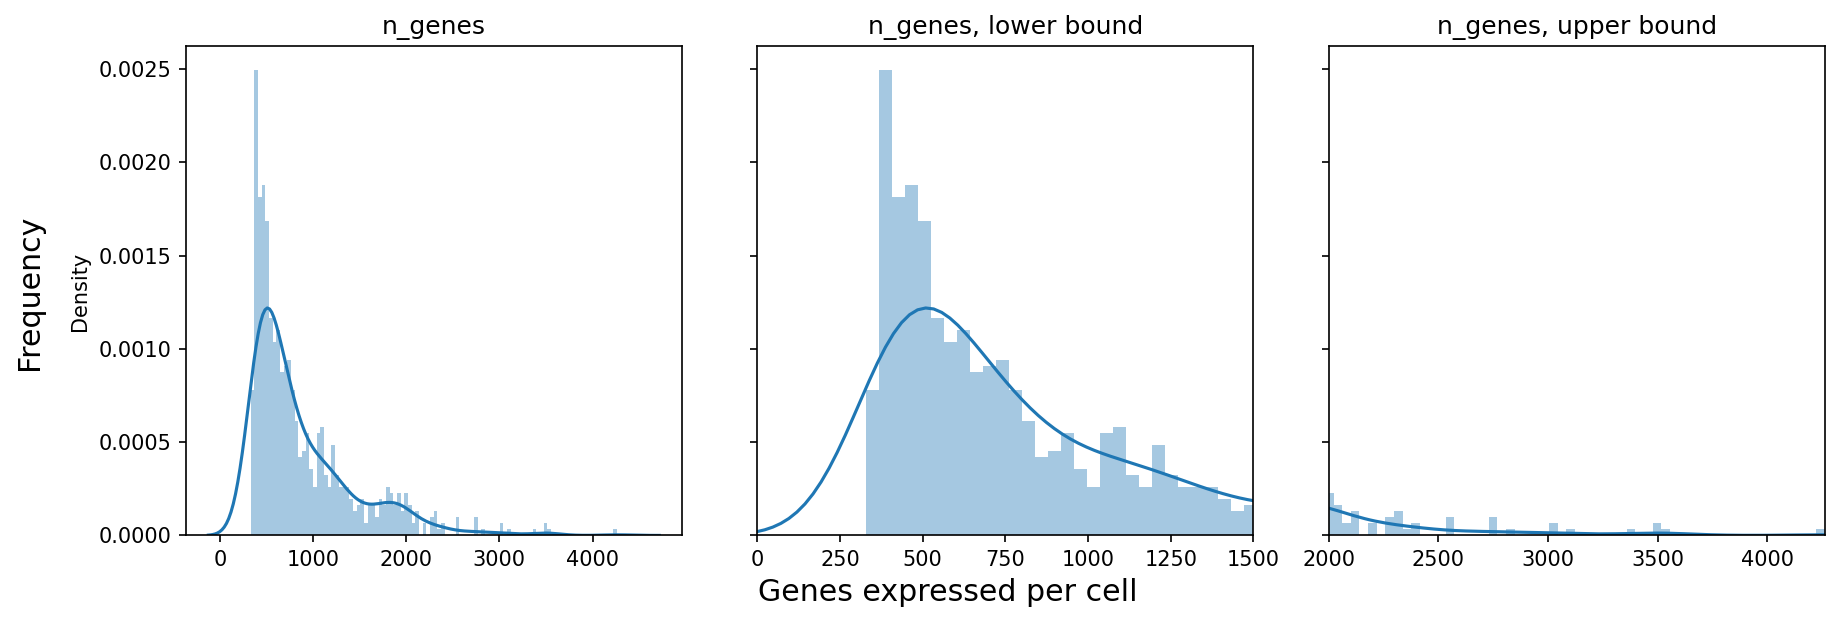

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, adata.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

In [17]:
#### Percentage of mitochondrial reads per cell

/Users/lidiayung/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

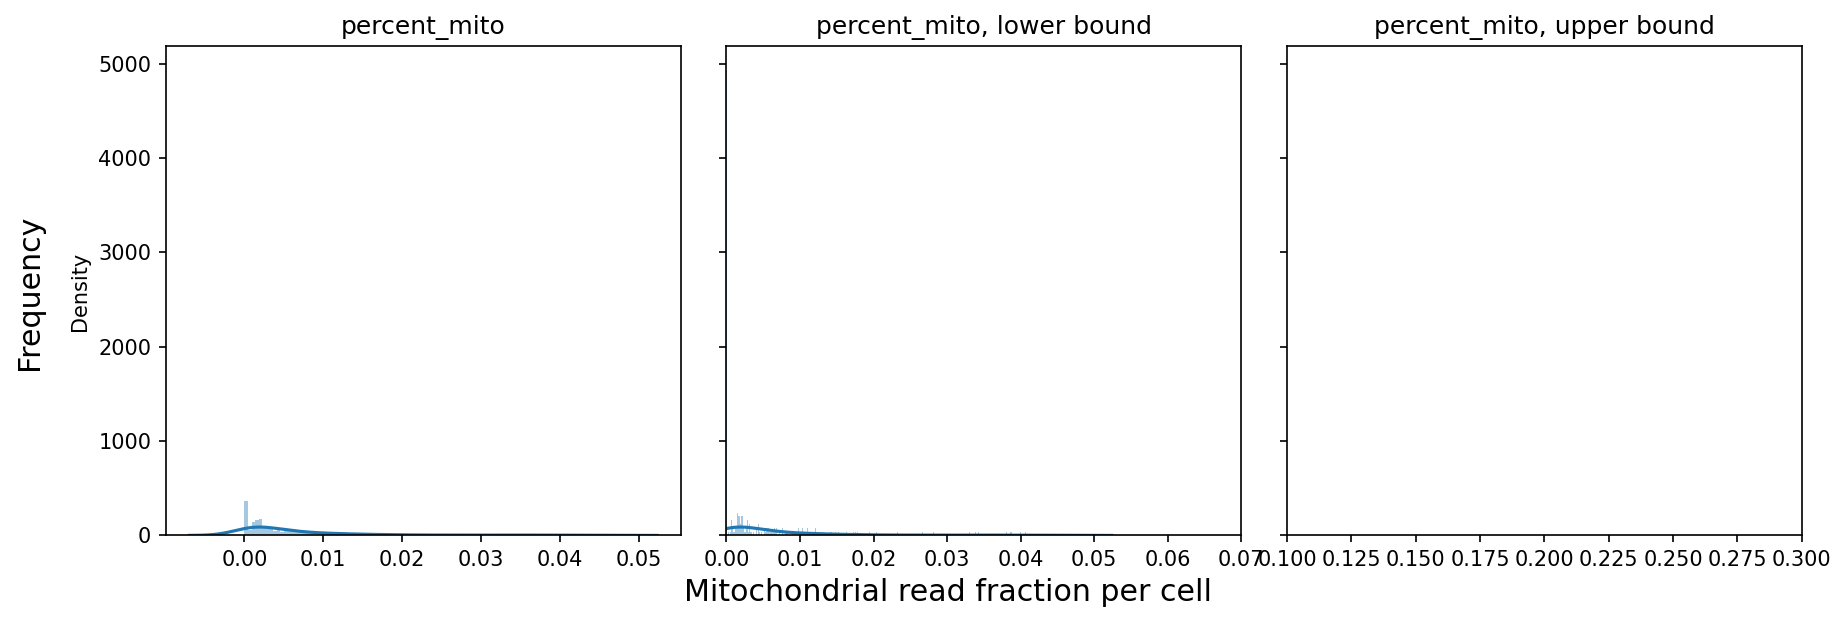

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = adata.obs['percent_mito']
x_lowerbound = [0.0, 0.07 ]
x_upperbound = [ 0.10, 0.3 ]
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=int(nbins/(x_lowerbound[1]-x_lowerbound[0])) )
sns.distplot(x, ax=ax3, norm_hist=True, bins=int(nbins/(x_upperbound[1]-x_upperbound[0])) )

ax2.set_xlim(x_lowerbound[0], x_lowerbound[1])
ax3.set_xlim(x_upperbound[0], x_upperbound[1] )
for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('percent_mito')
ax2.title.set_text('percent_mito, lower bound')
ax3.title.set_text('percent_mito, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Mitochondrial read fraction per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

#### Three-panel summary plots

/Users/lidiayung/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

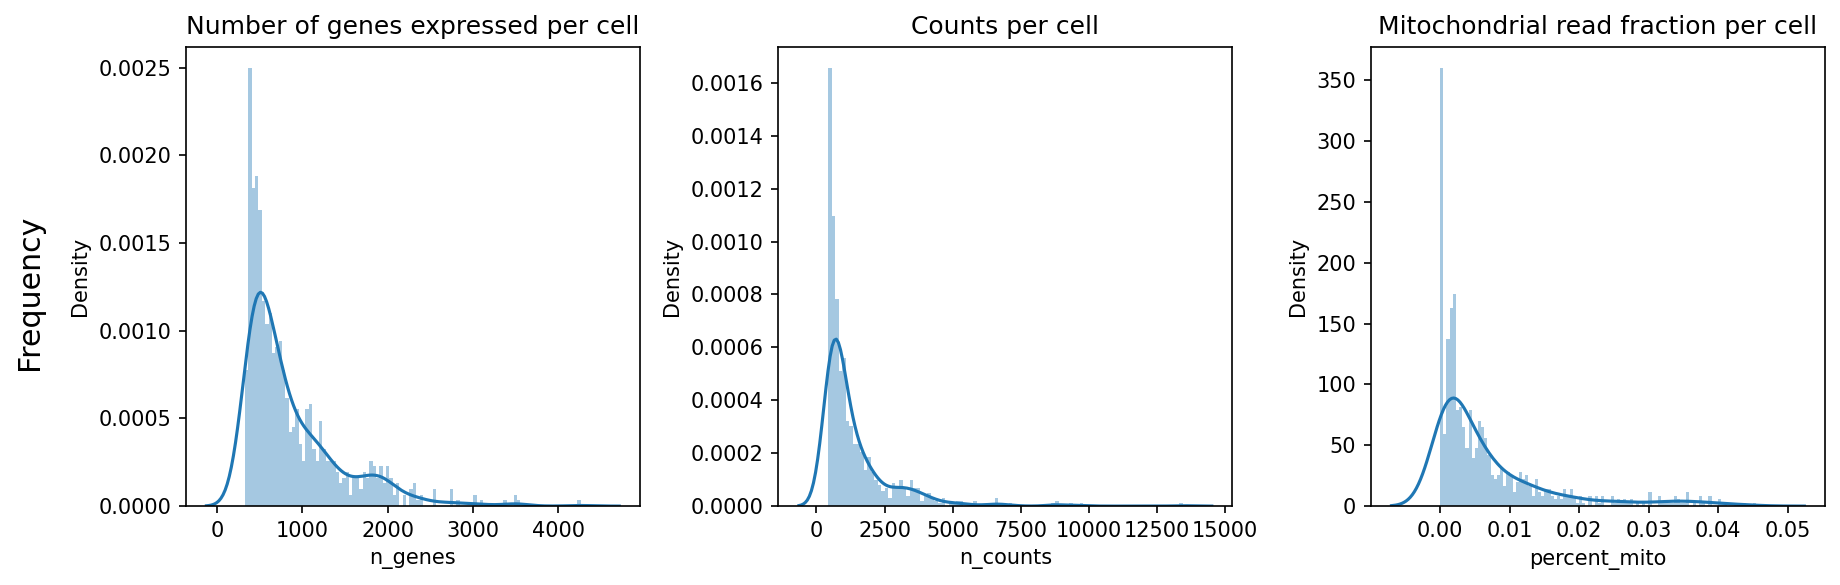

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_prefilter.pdf', dpi=600, bbox_inches='tight')

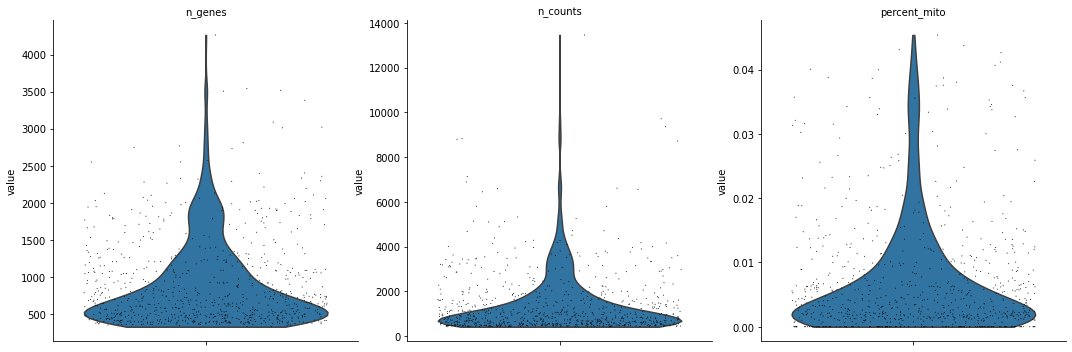

In [20]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

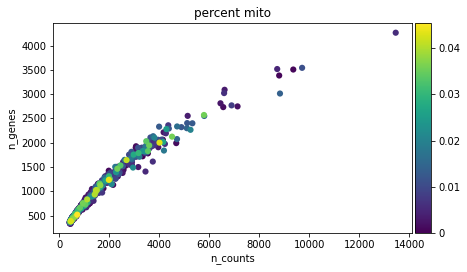

In [21]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

### Carry out the filtering steps:

In [22]:
# initial cuts
sc.pp.filter_cells(adata, min_genes=200 )
#sc.pp.filter_genes(adata, min_cells=3 )

In [23]:
#adata = adata[adata.obs['n_genes'] < 4000, :]
adata = adata[adata.obs['percent_mito'] <=0.025, :]

CellID
AAACCCAAGACTCCGC-1    0.000000
AAACGAAGTCGCATTA-1    0.009554
AAACGAATCGACACCG-1    0.001529
AAACGCTAGGCTTTCA-1    0.007856
AAAGGATAGTAATTGG-1    0.002217
                        ...   
TTTGACTTCACCTGTC-1    0.001963
TTTGACTTCTATCGCC-1    0.005607
TTTGGAGTCAAAGACA-1    0.001499
TTTGGAGTCTTCCACG-1    0.000000
TTTGGTTTCTCATAGG-1    0.000310
Name: percent_mito, Length: 735, dtype: float32

### Diagnostic plots, post filtering

In [24]:
#### Three-panel summary plots

/Users/lidiayung/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lidiayung/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

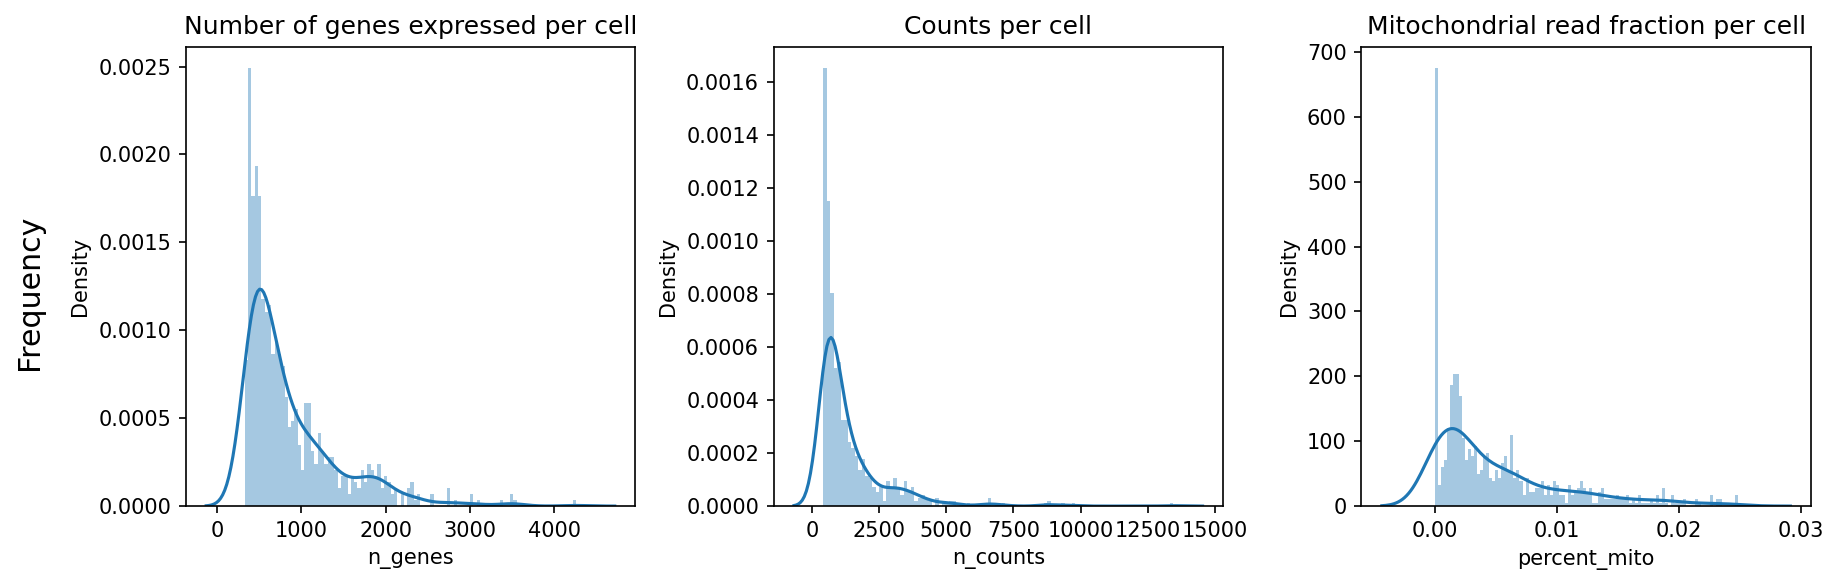

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)

adata.obs['n_genes']

sns.distplot( adata.obs['n_genes'], ax=ax1, norm_hist=True, bins=100)
sns.distplot( adata.obs['n_counts'], ax=ax2, norm_hist=True, bins=100)
sns.distplot( adata.obs['percent_mito'], ax=ax3, norm_hist=True, bins=100)

ax1.title.set_text('Number of genes expressed per cell')
ax2.title.set_text('Counts per cell')
ax3.title.set_text('Mitochondrial read fraction per cell')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')

fig.tight_layout()

fig.savefig('filtering_panel_postfilter.pdf', dpi=600, bbox_inches='tight')

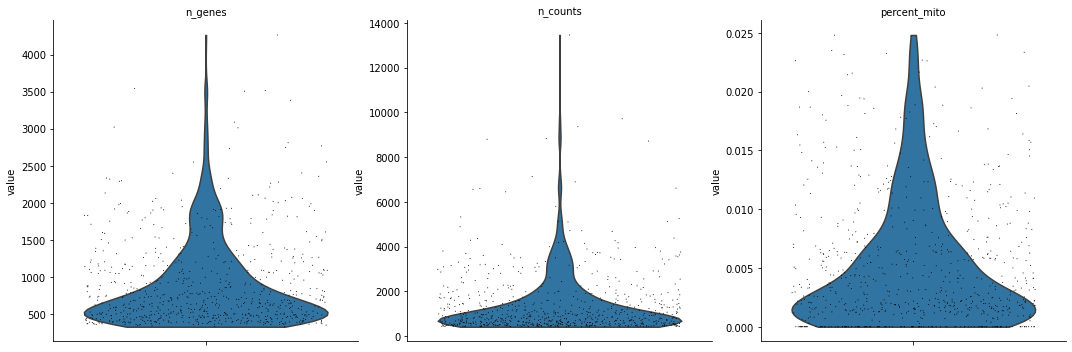

In [26]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
    jitter=0.4, multi_panel=True )

#### Scatter plot, n_genes by n_counts

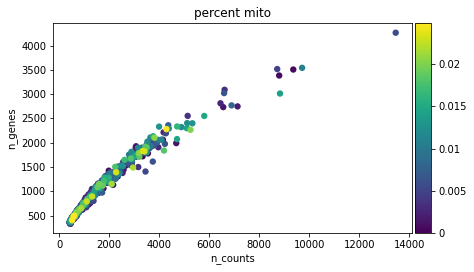

In [27]:
sc.pl.scatter(adata, x='n_counts', y='n_genes', color='percent_mito')

### Finalize the selected filters

Update the anndata file, to be used for further processing, clustering, visualization, etc..

In [28]:
adata.write( f_anndata_path )

Output the basic filtered expression matrix to a loom file.
This can also be used in the command-line pySCENIC steps, for example, or as an input to the Nextflow pipeline.

In [29]:
# create basic row and column attributes for the loom file:
row_attrs = {
    "Gene": np.array(adata.var_names) ,
}
col_attrs = {
    "CellID": np.array(adata.obs_names) ,
    "nGene": np.array( np.sum(adata.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata.X.transpose() , axis=0)).flatten() ,
}
lp.create( f_loom_path_scenic, adata.X.transpose(), row_attrs, col_attrs)

In [30]:
info = adata.X.transpose()
print(info.shape)
print('storing for SCENIC an expression matrix of {} cells by {} genes'.format(info.shape[1], info.shape[0]))
print('number of genes: {}'.format(len(adata.var_names)))
print('number of cells: {}'.format(len(adata.obs_names)))

(33694, 735)
storing for SCENIC an expression matrix of 735 cells by 33694 genes
number of genes: 33694
number of cells: 735


In [31]:
adata.obs.nUMI

CellID
AAACCCAAGACTCCGC-1     802.0
AAACGAAGTCGCATTA-1     628.0
AAACGAATCGACACCG-1     654.0
AAACGCTAGGCTTTCA-1    2164.0
AAAGGATAGTAATTGG-1     451.0
                       ...  
TTTGACTTCACCTGTC-1    7133.0
TTTGACTTCTATCGCC-1     535.0
TTTGGAGTCAAAGACA-1     667.0
TTTGGAGTCTTCCACG-1     432.0
TTTGGTTTCTCATAGG-1    3229.0
Name: nUMI, Length: 735, dtype: float32

In [32]:
file = "/Users/lidiayung/project/resource/GSM5319572_SF4324/GSE174554_Tumor_normal_metadata.txt"
metadata= pd.read_csv(file,sep=' ')
metadata.head()

,Sample#,Barcode,Tumor_Normal_annotation
0,SF10022,CTATCTAAGCAAGCCA,Tumor
1,SF10022,AAACCCAGTCTACGAT,Normal
2,SF10022,AAAGGGCTCACCCTGT,Normal
3,SF10022,AACAACCAGACCCGCT,Normal
4,SF10022,AACAAGAGTGTAAACA,Normal


In [33]:
SF4209 = metadata[metadata["Sample#"]=="SF4209"]

In [34]:
SF4209[SF4209['Tumor_Normal_annotation']=='Tumor']

,Sample#,Barcode,Tumor_Normal_annotation
72193,SF4209,TAAGCACTCCATCTCG,Tumor
72213,SF4209,AAACGAATCGACACCG,Tumor
72214,SF4209,AAAGTCCTCTGCCTGT,Tumor
72215,SF4209,AAATGGAGTGGGAGAG,Tumor
72216,SF4209,AAATGGAGTTAATGAG,Tumor
...,...,...,...
73092,SF4209,ACGTTCCGTCGCCACA,Tumor
73093,SF4209,AGAGAGCCAGTAACAA,Tumor
73094,SF4209,GATAGAACAAGAGCTG,Tumor
73095,SF4209,TCAAGACCAGTTGCGC,Tumor


In [35]:
SF4209['Barcode'] = SF4209['Barcode'].apply(lambda x: str(x) + '-1')


/var/folders/qq/n8l4bgxs53j_s3twq5jzc7g00000gn/T/ipykernel_3999/2008951624.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SF4209['Barcode'] = SF4209['Barcode'].apply(lambda x: str(x) + '-1')


In [36]:
df_barcodes = set(SF4209['Barcode'])
intersection_barcodes = df_barcodes.intersection(set(list(adata.obs.index)))
new_df = SF4209[SF4209['Barcode'].isin(intersection_barcodes)]
print(new_df)

      Sample#             Barcode Tumor_Normal_annotation
72190  SF4209  AACAACCCAAACCATC-1                  Normal
72191  SF4209  AGACTCAAGCCTTGAT-1                  Normal
72192  SF4209  CTCTCAGCAGATTTCG-1                  Normal
72193  SF4209  TAAGCACTCCATCTCG-1                   Tumor
72194  SF4209  TCACTCGGTTACCTGA-1                  Normal
...       ...                 ...                     ...
73092  SF4209  ACGTTCCGTCGCCACA-1                   Tumor
73093  SF4209  AGAGAGCCAGTAACAA-1                   Tumor
73094  SF4209  GATAGAACAAGAGCTG-1                   Tumor
73096  SF4209  TTCCTCTGTACATTGC-1                   Tumor
73103  SF4209  CATGGATTCCAAGCTA-1                  Normal

[735 rows x 3 columns]


In [37]:
print(new_df[new_df['Tumor_Normal_annotation']=='Tumor'])

      Sample#             Barcode Tumor_Normal_annotation
72193  SF4209  TAAGCACTCCATCTCG-1                   Tumor
72213  SF4209  AAACGAATCGACACCG-1                   Tumor
72214  SF4209  AAAGTCCTCTGCCTGT-1                   Tumor
72215  SF4209  AAATGGAGTGGGAGAG-1                   Tumor
72216  SF4209  AAATGGAGTTAATGAG-1                   Tumor
...       ...                 ...                     ...
73089  SF4209  CATGGTACATCCGAAT-1                   Tumor
73092  SF4209  ACGTTCCGTCGCCACA-1                   Tumor
73093  SF4209  AGAGAGCCAGTAACAA-1                   Tumor
73094  SF4209  GATAGAACAAGAGCTG-1                   Tumor
73096  SF4209  TTCCTCTGTACATTGC-1                   Tumor

[633 rows x 3 columns]


## Further pre-processing of expression data

In [ ]:
# save a copy of the raw data
adata.raw = adata

# Total-count normalize (library-size correct) to 10,000 reads/cell
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# log transform the data.
sc.pp.log1p(adata)

# identify highly variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

# keep only highly variable genes:
adata = adata[:, adata.var['highly_variable']]

# regress out total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'] ) #, n_jobs=args.threads)

# scale each gene to unit variance, clip values exceeding SD 10.
sc.pp.scale(adata, max_value=10)

# update the anndata file:
adata.write( f_anndata_path )

### 1 PCA

In [ ]:
# adata = sc.read_h5ad( f_anndata_path )
# principal component analysis
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
adata.write( f_anndata_path )

### 2 Visualization of highly variable genes

In [ ]:
# neighborhood graph of cells (determine optimal number of PCs here)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
# compute UMAP
sc.tl.umap(adata)
# tSNE
tsne = TSNE( n_jobs=2 )
adata.obsm['X_tsne'] = tsne.fit_transform( adata.X )
adata.write( f_anndata_path )

### 3 Clustering

In [ ]:
# cluster the neighbourhood graph
sc.tl.louvain(adata, resolution=0.4)

sc.pl.umap(adata, color=['louvain'] )

In [ ]:
# find marker genes
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

# sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
# sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
adata.write( f_anndata_path )

In [ ]:
### 4 distribution of genes per cell

In [ ]:
nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)
nGenesDetectedPerCell = pd.Series(nGenesDetectedPerCell)
percentiles = nGenesDetectedPerCell.quantile([0.01, 0.05, 0.10, 0.50, 1])
print(percentiles)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

## SCENIC

In [ ]:
f_tfs = "/home/jing/scratch/resource/allTFs_hg38.txt"

In [ ]:
!pyscenic grn {f_loom_path_scenic} {f_tfs} -o adj.csv --num_workers 8

In [ ]:
adjacencies = pd.read_csv("adj.csv", index_col=False, sep='\t')

In [ ]:
adjacencies.head()

In [ ]:
adjacencies.head()

In [ ]:
import glob
# ranking databases
f_db_glob = "/home/jing/scratch/resource/*feather"
f_db_names = ' '.join( glob.glob(f_db_glob) )

# motif databases
f_motif_path = "/home/jing/scratch/resource/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

In [ ]:
!pyscenic ctx adj.csv \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname {f_loom_path_scenic} \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 8

In [ ]:
nGenesDetectedPerCell = np.sum(adata.X>0, axis=1)
nGenesDetectedPerCell = pd.Series(nGenesDetectedPerCell)
percentiles = nGenesDetectedPerCell.quantile([0.01, 0.05, 0.10, 0.50, 1])
print(percentiles)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=150)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [ ]:
!pyscenic aucell \
    {f_loom_path_scenic} \
    reg.csv \
    --output {f_pyscenic_output} \
    --num_workers 8

In [ ]:
import json
import zlib
import base64
import loompy as lp
import pandas as pd

# collect SCENIC AUCell output
lf = lp.connect(f_pyscenic_output, mode='r+', validate=False)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [ ]:
auc_mtx.shape

In [ ]:
sns.clustermap(auc_mtx, figsize=(12,12))

In [ ]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')
# tSNE
tsne = TSNE( n_jobs=8 )
dr_tsne = tsne.fit_transform( auc_mtx )
pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_tsne.txt", sep='\t')

In [ ]:
pdf = pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index)
pdf.head()

In [ ]:
plt.plot(pdf['X'], pdf['Y'], 'o', alpha=1/13)
plt.show()

In [ ]:
pdf = pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index)
plt.plot(pdf['X'], pdf['Y'], 'o', alpha=1/13)
plt.show()

In [ ]:
# scenic output
lf = lp.connect( f_pyscenic_output, mode='r+', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
#exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID)
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
regulons = lf.ra.Regulons
dr_umap = pd.read_csv( 'scenic_umap.txt', sep='\t', header=0, index_col=0 )
dr_tsne = pd.read_csv( 'scenic_tsne.txt', sep='\t', header=0, index_col=0 )
###

In [ ]:
auc_mtx.columns = auc_mtx.columns.str.replace('\(','_(')
regulons.dtype.names = tuple( [ x.replace("(","_(") for x in regulons.dtype.names ] )
# regulon thresholds
rt = meta['regulonThresholds']
for i,x in enumerate(rt):
    tmp = x.get('regulon').replace("(","_(")
    x.update( {'regulon': tmp} )

In [ ]:
tsneDF = pd.DataFrame(adata.obsm['X_tsne'], columns=['_X', '_Y'])

Embeddings_X = pd.DataFrame( index=lf.ca.CellID )
Embeddings_X = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[0] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[0] ,
        dr_tsne['X'] ,
        dr_umap['X']
    ], sort=False, axis=1, join='outer' )
Embeddings_X.columns = ['1','2','3','4']

Embeddings_Y = pd.DataFrame( index=lf.ca.CellID )
Embeddings_Y = pd.concat( [
        pd.DataFrame(adata.obsm['X_umap'],index=adata.obs.index)[1] ,
        pd.DataFrame(adata.obsm['X_pca'],index=adata.obs.index)[1] ,
        dr_tsne['Y'] ,
        dr_umap['Y']
    ], sort=False, axis=1, join='outer' )
Embeddings_Y.columns = ['1','2','3','4']

In [ ]:
metaJson = {}

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": f"Scanpy t-SNE (highly variable genes)"
    },
    {
        "id": 1,
        "name": f"Scanpy UMAP  (highly variable genes)"
    },
    {
        "id": 2,
        "name": "Scanpy PC1/PC2"
    },
    {
        "id": 3,
        "name": "SCENIC AUC t-SNE"
    },
    {
        "id": 4,
        "name": "SCENIC AUC UMAP"
    },
]

metaJson["clusterings"] = [{
            "id": 0,
            "group": "Scanpy",
            "name": "Scanpy louvain default resolution",
            "clusters": [],
        }]

metaJson["metrics"] = [
        {
            "name": "nUMI"
        }, {
            "name": "nGene"
        }, {
            "name": "Percent_mito"
        }
]

metaJson["annotations"] = [
    {
        "name": "Louvain_clusters_Scanpy",
        "values": list(set( adata.obs['louvain'].astype(np.str) ))
    },
    #{
    #    "name": "Genotype",
    #    "values": list(set(adata.obs['Genotype'].values))
    #},
    #{
    #    "name": "Timepoint",
    #    "values": list(set(adata.obs['Timepoint'].values))
    #},
    #{
    #    "name": "Sample",
    #    "values": list(set(adata.obs['Sample'].values))
    #}
]

# SCENIC regulon thresholds:
metaJson["regulonThresholds"] = rt

for i in range(max(set([int(x) for x in adata.obs['louvain']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i + 1}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)
    
clusterings = pd.DataFrame()
clusterings["0"] = adata.obs['louvain'].values.astype(np.int64)

In [ ]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.values]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

In [ ]:
col_attrs = {
    "CellID": np.array(adata.obs.index),
    "nUMI": np.array(adata.obs['n_counts'].values),
    "nGene": np.array(adata.obs['n_genes'].values),
    "Louvain_clusters_Scanpy": np.array( adata.obs['louvain'].values ),
    #"Genotype": np.array(adata.obs['Genotype'].values),
    #"Timepoint": np.array(adata.obs['Timepoint'].values),
    #"Sample": np.array(adata.obs['Sample'].values),
    "Percent_mito": np.array(adata.obs['percent_mito'].values),
    "Embedding": dfToNamedMatrix(tsneDF),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "RegulonsAUC": dfToNamedMatrix(auc_mtx),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['louvain'].values)
}

row_attrs = {
    "Gene": lf.ra.Gene,
    "Regulons": regulons,
}

attrs = {
    "title": "sampleTitle",
    "MetaData": json.dumps(metaJson),
    "Genome": 'hg38',
    "SCopeTreeL1": "",
    "SCopeTreeL2": "",
    "SCopeTreeL3": ""
}

# compress the metadata field:
attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

In [ ]:
lp.create(
    filename = "f_final_loom" ,
    layers=lf[:,:],
    row_attrs=row_attrs, 
    col_attrs=col_attrs, 
    file_attrs=attrs
)
lf.close() # close original pyscenic loom file